In [2]:
import torch
from ultralytics import YOLO
from attacks import disappearance_dag_attack,targeted_dag_attack, fool_detectors_attack, fgsm_attack_detector
from util import compare_original_and_adversarial, compare_original_and_adversarial_png


In [3]:
model = YOLO("yolov8n_TrafficSigns.pt")
image_path="road.jpg"

# Disappearance DAG Attack Documentation

---

## 1. Attack Idea
This attack is inspired by the **Dense Adversary Generation (DAG)** algorithm. It generates imperceptible perturbations to make object detections "disappear" by suppressing their confidence scores in YOLOv8. Unlike targeted attacks, it does NOT specify new classes for predictions.

---

## 2. Attack Steps & Loss Function

### Key Steps:
1. **Target Selection**: Find all detections with confidence > `conf_threshold`.
2. **Loss Calculation**: Minimize the model's confidence for these detections.
3. **Gradient Update**: Perturb the image iteratively using L-infinity bounded steps.

### Loss Function:
The loss aims to reduce logits (pre-sigmoid scores) of predicted classes:
$$
\text{Loss} = -\sum_{i \in \text{targets}} \text{logit}(c_i)
$$
where:
- $c_i$ = predicted class for detection $i$
- $\text{logit}(c_i)$ = raw output score for class $c_i$

---

## 3. Implementation Summary
```python
def disappearance_dag_attack(...):
    # 1. Load YOLO models (raw + high-level)
    # 2. Preprocess image to tensor
    # 3. For N iterations:
    #    a) Get raw model predictions
    #    b) Select high-confidence detections
    #    c) Compute loss over targets
    #    d) Update image: image += gamma * sign(gradient)
    # 4. Return perturbed image
```

---

## 4. Usage Example
```python
from ultralytics import YOLO

# Generate adversarial image
adv_image = disappearance_dag_attack(
    image_path="test.jpg",
    num_iterations=15,
    gamma=0.05,
    device="cuda"
)

# Compare results
model = YOLO("yolov8n.pt")
model.predict("test.jpg")[0].show()     # Original detections
model.predict(adv_image)[0].show()      # Objects disappear
```
## **paper:**
Adversarial Examples for Semantic Segmentation and Object Detection

In [10]:
adv_image = disappearance_dag_attack(image_path, raw_model_path="yolov8n_TrafficSigns.pt", high_level_model_path="yolov8n_TrafficSigns.pt",num_iterations=20, gamma=0.003,conf_threshold=0.25)


0: 448x640 1 Stop, 171.7ms
Speed: 0.0ms preprocess, 171.7ms inference, 3.8ms postprocess per image at shape (1, 3, 448, 640)
Iteration 0: #rows_to_attack=74, loss=-7.9000

0: 448x640 1 Stop, 133.7ms
Speed: 0.0ms preprocess, 133.7ms inference, 3.9ms postprocess per image at shape (1, 3, 448, 640)
Iteration 1: #rows_to_attack=36, loss=-2.5112

0: 448x640 (no detections), 288.9ms
Speed: 0.0ms preprocess, 288.9ms inference, 10.7ms postprocess per image at shape (1, 3, 448, 640)
Iteration 2: no rows above threshold => stopping early.


Running prediction on original tensor...



0: 448x640 1 Stop, 193.8ms
Speed: 0.0ms preprocess, 193.8ms inference, 3.3ms postprocess per image at shape (1, 3, 448, 640)
Running prediction on loaded adversarial tensor...

0: 448x640 (no detections), 460.0ms
Speed: 0.0ms preprocess, 460.0ms inference, 3.8ms postprocess per image at shape (1, 3, 448, 640)


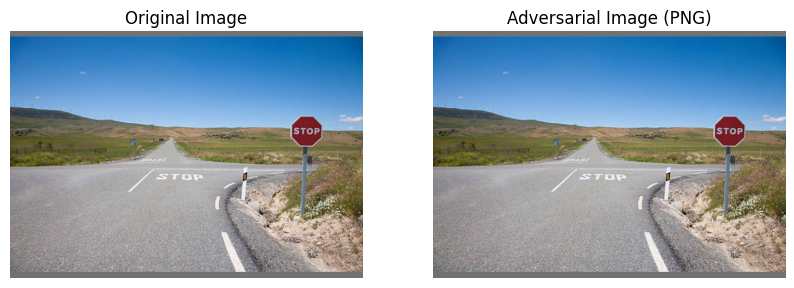

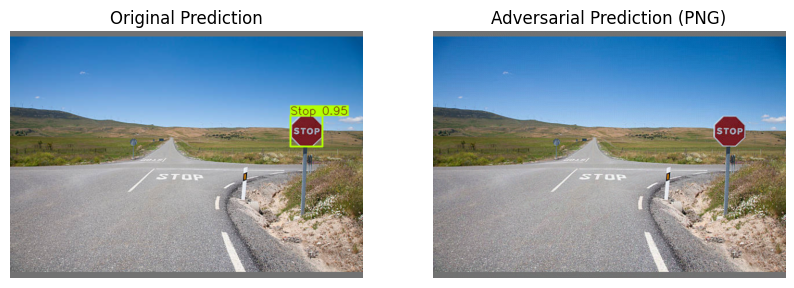

In [11]:
compare_original_and_adversarial_png(model ,image_path,adv_image,0.25)

# Targeted DAG Attack Documentation

---

## 1. Attack Idea
This **targeted attack** modifies the DAG algorithm to push all detections toward a specific adversarial class. It combines:
1. **Suppression** of original high-confidence detections
2. **Promotion** of a chosen adversarial class
3. **Early stopping** when the adversarial class dominates

---

## 2. Attack Steps & Loss Function

### Key Stages:
1. **Initial Analysis**: Identify original high-confidence classes
2. **Targeted Perturbation**:
   - Push original detections toward adversarial class
   - If no originals remain, boost adversarial class globally
3. **Termination**: Stop when adversarial class appears and originals disappear

### Loss Function
The loss has two modes depending on remaining targets:

1. **Targeted Mode** (original detections present):
$$
\text{Loss} = \sum_{i \in \text{targets}} (\text{logit}_{\text{adv}}^{(i)} - \text{logit}_{\text{orig}}^{(i)})
$$
- $\text{logit}_{\text{adv}}$: Adversarial class score
- $\text{logit}_{\text{orig}}$: Original class score

2. **Global Promotion Mode** (no originals left):
$$
\text{Loss} = \sum_{i} \text{logit}_{\text{adv}}^{(i)}
$$

---

## 3. Implementation Summary
```python
def targeted_dag_attack(...):
    # 1. Load YOLO models (raw + high-level)
    # 2. Get original predictions to determine target classes
    # 3. For N iterations:
    #    a) Calculate class logits from raw model
    #    b) Select rows with original classes
    #    c) Compute loss based on current mode
    #    d) Update image: image += gamma * sign(gradient)
    #    e) Check stop condition (adv_class present + targets gone)
    # 4. Return perturbed image and stop status
```

---

## 4. Usage Example
```python
from ultralytics import YOLO

# Convert cat detections to "truck" (class 7)
adv_image, stopped_early = targeted_dag_attack(
    image_path="cat.jpg",
    adversarial_class=7,    # COCO class index for truck
    num_iterations=20,
    gamma=0.04,
    conf_threshold=0.3,
    device="cuda"
)

# Analyze results
model = YOLO("yolov8n.pt")
print("Original classes:", model("cat.jpg")[0].boxes.cls.unique())
print("Adversarial classes:", model(adv_image)[0].boxes.cls.unique())
```
## **paper:**
Adversarial Examples for Semantic Segmentation and Object Detection

In [8]:
adv_image_targeted, succsess = targeted_dag_attack(
    image_path=image_path,
    raw_model_path="yolov8n_TrafficSigns.pt",
    high_level_model_path="yolov8n_TrafficSigns.pt",
    adversarial_class=0,
    num_iterations=50,
    gamma=0.003,
    conf_threshold=0.25,
    device='cpu')


0: 448x640 1 Stop, 220.8ms
Speed: 0.0ms preprocess, 220.8ms inference, 3.9ms postprocess per image at shape (1, 3, 448, 640)
Original classes above conf=0.25: {14}

0: 448x640 1 Stop, 248.9ms
Speed: 0.0ms preprocess, 248.9ms inference, 5.0ms postprocess per image at shape (1, 3, 448, 640)
Iteration 0: #rows_to_attack=74, loss=-7.8994

0: 448x640 (no detections), 254.2ms
Speed: 0.0ms preprocess, 254.2ms inference, 3.8ms postprocess per image at shape (1, 3, 448, 640)
Iteration 1: #rows_to_attack=35, loss=-2.5098

0: 448x640 (no detections), 197.6ms
Speed: 0.0ms preprocess, 197.6ms inference, 2.9ms postprocess per image at shape (1, 3, 448, 640)
Iteration 2: #rows_to_attack=16, loss=-0.0008

0: 448x640 (no detections), 171.3ms
Speed: 0.0ms preprocess, 171.3ms inference, 4.7ms postprocess per image at shape (1, 3, 448, 640)
Iteration 3: #rows_to_attack=3, loss=-0.0000

0: 448x640 (no detections), 171.1ms
Speed: 0.0ms preprocess, 171.1ms inference, 3.8ms postprocess per image at shape (1,

Running prediction on original tensor...



0: 448x640 1 Stop, 360.6ms
Speed: 0.1ms preprocess, 360.6ms inference, 3.5ms postprocess per image at shape (1, 3, 448, 640)
Running prediction on loaded adversarial tensor...

0: 448x640 2 Green Lights, 149.6ms
Speed: 0.0ms preprocess, 149.6ms inference, 7.8ms postprocess per image at shape (1, 3, 448, 640)


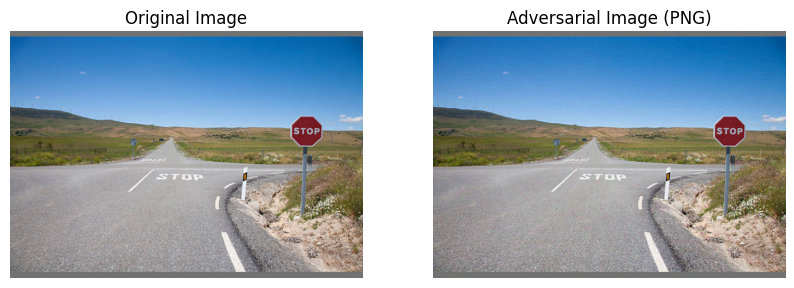

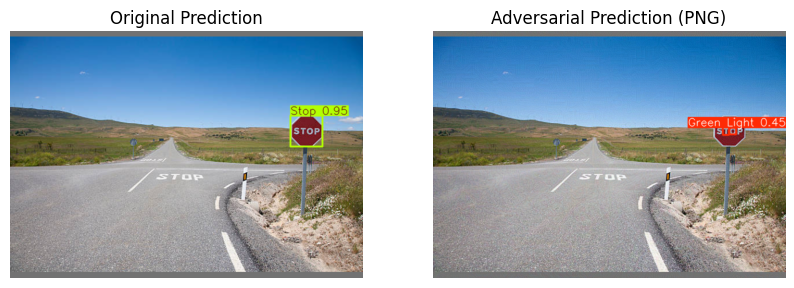

In [9]:
compare_original_and_adversarial_png(model ,image_path,adv_image_targeted ,0.25)

# Fool Detectors Attack Documentation

---

## 1. Attack Idea
This attack implements a **targeted adversarial attack** on object detectors (YOLOv8) inspired by the paper ["Adversarial Examples that Fool Detectors"](#). It generates perturbations to:
1. **Suppress target classes**: Reduce detection confidence for specified COCO classes (e.g., stop signs)
2. **Maintain stealth**: Use L2 regularization to keep adversarial images visually similar to originals
3. **Enable early stopping**: Terminate if target classes are no longer detected

---

## 2. Attack Steps & Loss Function

### Key Components from the Paper:
1. **Detector Vulnerability**: Exploits the detector's sensitivity to gradient patterns in class logits
2. **Multi-Objective Optimization**:
   - Minimize mean confidence of target classes
   - Constrain perturbations to stay near original image (L2 penalty)

### Mathematical Formulation
**Total Loss**:
$$
\text{Loss} = \underbrace{\frac{1}{N}\sum_{i=1}^{N} \text{conf}(c_{\text{target}}^{(i)}}_{\text{Detection Loss}} + \underbrace{\lambda \cdot ||\mathbf{X}_{\text{adv}} - \mathbf{X}_{\text{orig}}||_2^2}_{\text{L2 Regularization}}
$$

Where:
- $c_{\text{target}}$: Target class(es) to suppress
- $\lambda$: Regularization strength (`lambda_reg`)
- $N$: Number of bounding box proposals

---

## 3. Implementation Overview

```python
def fool_detectors_attack(...):
    # 1. Load YOLO models (raw model for gradients, high-level for detection)
    # 2. Preprocess image to tensor [1, 3, H, W]
    # 3. For N iterations:
    #    a) Compute class confidences for target classes
    #    b) Calculate detection loss + L2 penalty
    #    c) Backpropagate gradients
    #    d) Update image: X = X - γ * sign(∇Loss)
    #    e) Early stop if target classes disappear
    # 4. Return adversarial image
```

### Key Components:
| Component               | Description                                                                 |
|-------------------------|-----------------------------------------------------------------------------|
| **Raw Model**           | YOLO backbone without post-processing for gradient computation             |
| **High-Level Model**    | Full YOLO with NMS to check detection results                               |
| **L-inf Update**        | `image -= gamma * grad.sign()` ensures bounded perturbations               |
| **Early Stopping**      | Monitors high-level model predictions for target class disappearance        |

---

## 4. Usage Example

```python
from ultralytics import YOLO
import torch

# Initialize attack (targeting stop signs - COCO class 11)
adv_image = fool_detectors_attack(
    image_path="stop_sign.jpg",
    target_classes=[11],          # COCO class 11 = stop sign
    num_iterations=20,
    gamma=0.05,
    lambda_reg=0.1,               # Balance stealth vs effectiveness
    conf_threshold=0.3,
    device="cuda"
)

# Compare results
model = YOLO("yolov8n.pt")

# Original image
orig_results = model("stop_sign.jpg")[0]
print("Original detections:", orig_results.boxes.cls.tolist())  # e.g., [11, 11]

# Adversarial image 
adv_results = model(adv_image)[0]
print("Adversarial detections:", adv_results.boxes.cls.tolist())  # e.g., []
```
## **paper:**
Adversarial Examples that Fool Detectors

In [19]:
# Run the attack
adv_image = fool_detectors_attack(
    image_path=image_path,
    raw_model_path="yolov8n_TrafficSigns.pt",
    high_level_model_path="yolov8n_TrafficSigns.pt",
    num_iterations=20,
    gamma=0.01,
    conf_threshold=0.25,
    lambda_reg=0.01,
    target_classes = [14],
    device='cpu'
)


0: 448x640 1 Stop, 442.8ms
Speed: 0.0ms preprocess, 442.8ms inference, 8.2ms postprocess per image at shape (1, 3, 448, 640)
Iteration 0: Loss_det=0.5003, Loss_L2=0.0000, Total_loss=0.5003

0: 448x640 (no detections), 177.2ms
Speed: 0.0ms preprocess, 177.2ms inference, 4.1ms postprocess per image at shape (1, 3, 448, 640)
Iteration 1: No target objects detected. Early stopping.


Running prediction on original tensor...

0: 448x640 1 Stop, 210.7ms
Speed: 0.0ms preprocess, 210.7ms inference, 5.1ms postprocess per image at shape (1, 3, 448, 640)
Running prediction on loaded adversarial tensor...

0: 448x640 (no detections), 202.5ms
Speed: 0.0ms preprocess, 202.5ms inference, 3.6ms postprocess per image at shape (1, 3, 448, 640)


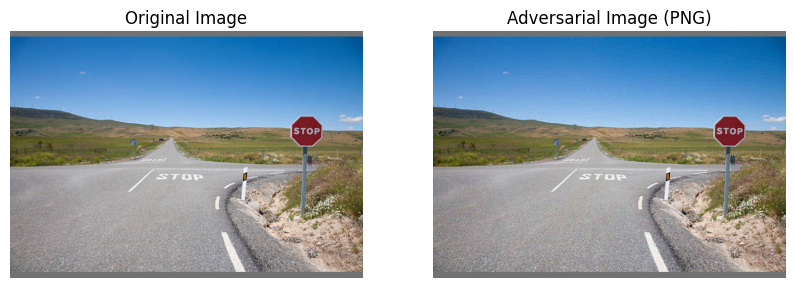

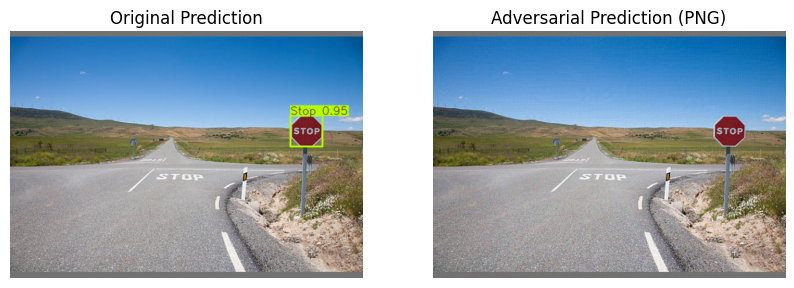

In [20]:
compare_original_and_adversarial_png(model, image_path, adv_image,0.25)

# FGSM Attack for Object Detectors Documentation

---

## 1. Attack Idea
This implementation adapts the **Fast Gradient Sign Method (FGSM)** for object detection models (YOLOv8). The attack:
1. **Targets High-Confidence Detections**: Focuses on predictions with confidence > specified threshold  
2. **Maximizes Classification Error**: Perturbs image to confuse class predictions  
3. **Optional Bounding Box Disruption**: Can simultaneously degrade localization accuracy (disabled by default)  
4. **Maintains Stealth**: Uses L-infinity bounded perturbations (ε typically 0.01-0.1)  
5. **One shot**: not iterative so it is fast and suitable for adversarial training

---

## 2. Attack Steps & Loss Function

### Key Components from FGSM Paper:
1. **Linear Explanation**: Exploits gradient sign direction for efficient perturbation  
2. **Single-Step Attack**: Computes perturbation in one forward/backward pass  

### Mathematical Formulation:
**Total Loss**:
$$
\mathcal{L}_{\text{total}} = \underbrace{-\sum_{i \in \mathcal{D}} \log(p(y_i|\mathbf{x}))}_{\text{Classification Loss}} + \lambda \underbrace{||\mathbf{x}_{\text{adv}} - \mathbf{x}_{\text{orig}}||_2}_{\text{Implicit L2 Constraint}}
$$

Where:
- $\mathcal{D}$ = High-confidence detections  
- $p(y_i|\mathbf{x})$ = Class probability for detection $i$  
- $\lambda$ = Implicitly controlled via ε clamping  

---

## 3. Implementation Overview

### Pipeline:
```python
1. Load YOLOv8 detection model
2. Preprocess input image (normalization + resizing)
3. Extract raw model outputs (bypass NMS/post-processing)
4. Calculate combined confidence scores (objectness × class probability)
5. Filter detections by confidence threshold
6. Compute classification loss between original and current predictions
7. Backpropagate loss to get image gradient
8. Apply perturbation: x_adv = x + ε·sign(∇x ℒ)
9. Clamp to valid pixel range [0,1]
```

### Key Components:
| Component               | Description                                                                 |
|-------------------------|-----------------------------------------------------------------------------|
| **Raw Output Extraction** | Accesses model backbone outputs before non-max suppression                 |
| **Confidence Filtering**  | Combines objectness and class probability for detection quality assessment |
| **Gradient Isolation**    | Only perturbs high-confidence detections via boolean masking              |
| **Device Agnostic**       | Works on both CPU/GPU with automatic tensor placement                      |

---

## 4. Usage Example

```python
from attacks import fgsm_attack_detector
from ultralytics import YOLO

# Generate adversarial example
adv_image = fgsm_attack_detector(
    image_path="highway.jpg",
    model_path="yolov8n.pt",
    epsilon=0.08,        # Moderate perturbation
    conf_threshold=0.6,  # Target confident detections
    device="cuda"
)

# Evaluate attack effectiveness
model = YOLO("yolov8n.pt").to("cuda")
original_results = model("highway.jpg")[0]
adversarial_results = model(adv_image)[0]

print(f"Original detections: {len(original_results.boxes)}")
print(f"Adversarial detections: {len(adversarial_results.boxes)}")
```

## 8. papers

1. **Original FGSM Paper**:  
   [Explaining and Harnessing Adversarial Examples (Goodfellow et al., 2015)](https://arxiv.org/abs/1412.6572)

2. **Object Detector Attacks**:  
   [Adversarial Examples for Object Detectors (Lu et al., 2017)](https://arxiv.org/abs/1712.08063)

3. **YOLOv8 Documentation**:  
   [Ultralytics YOLOv8 Docs](https://docs.ultralytics.com/)


In [14]:
adv_image= fgsm_attack_detector(
    image_path= image_path,
    model_path = 'yolov8n_TrafficSigns.pt',
    epsilon=  0.15,
    conf_threshold= 0.5,
    device = 'cpu'
)

Running prediction on original tensor...

0: 448x640 1 Stop, 221.7ms
Speed: 0.0ms preprocess, 221.7ms inference, 7.6ms postprocess per image at shape (1, 3, 448, 640)
Running prediction on loaded adversarial tensor...

0: 448x640 (no detections), 158.4ms
Speed: 0.0ms preprocess, 158.4ms inference, 3.5ms postprocess per image at shape (1, 3, 448, 640)


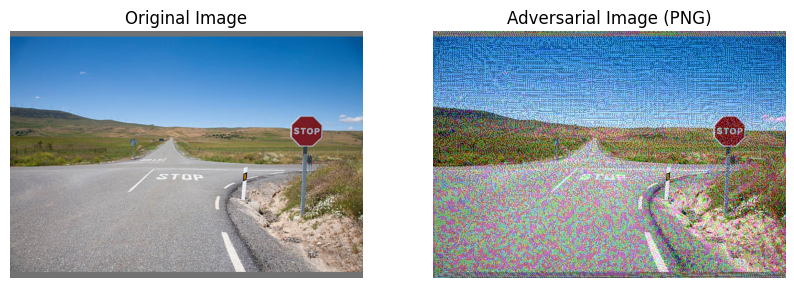

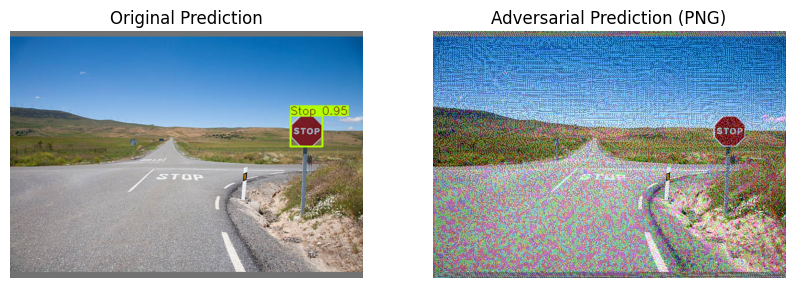

In [15]:
compare_original_and_adversarial_png(model, image_path, adv_image,0.5)